# 009 Network Analysis
* Origin-destination analysis
* Define mobility behavior before, during, and after the hurricane
* Create Fig3 a 
* Mapping and additional analysis have been done in Quantum GIS version 3.4 Madeira

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from numpy import arange
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import random
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check package versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

pandas 1.1.2
numpy 1.19.2
networkx 2.3
matplotlib 3.2.0
geopandas 0.8.1


# 1. Load data
* Home locations from DBSCAN
* Pre-hurricane home locations
* Home locations of hurricane period 1
* Home locations of hurricane period 2
* Post-hurricane home locations

In [3]:
home = pd.read_csv('../../outputs/houston/clusters_top25_users_Harvey_activity.csv', 
                 usecols=['id', 'home.1', 'home'], skiprows=[1])
home.columns = ['id', 'y_home', 'x_home']
df_pre = pd.read_csv('../../outputs/data_prep_network_pre.csv') # ~08/20
df_h1 = pd.read_csv('../../outputs/data_prep_network_h1.csv') # 08/25~08/30
df_h2 = pd.read_csv('../../outputs/data_prep_network_h2.csv') # 08/31~09/04
df_post = pd.read_csv('../../outputs/data_prep_network_post.csv') # 9/5~9/10

In [4]:
home.head(2)

,id,y_home,x_home
0,5F265B5D-F46D-4F1B-9549-F0E48A60E224,32.446467,-91.494068
1,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,29.968607,-95.209699


In [5]:
df_pre.head(2)

,id,x_pre,y_pre
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05


In [6]:
df_h1.head(2)

,id,x_h1,y_h1
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-90.00,35.00
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05


# 2. Merge data 

In [7]:
df = pd.merge(df_pre, df_h1, how='left', on='id')
df = pd.merge(df, df_h2, how='left', on='id')
df = pd.merge(df, df_post, how='left', on='id')
df = pd.merge(df, home, how='left', on='id')
df['x_home'] = df['x_home'].round(2)
df['y_home'] = df['y_home'].round(2)
df = df[['id', 'x_home', 'y_home', 'x_pre', 'y_pre', 'x_h1', 'y_h1', 'x_h2', 'y_h2', 'x_post', 'y_post']]

print (len(df))
df.head()

66634


,id,x_home,y_home,x_pre,y_pre,x_h1,y_h1,x_h2,y_h2,x_post,y_post
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-95.21,29.97,-90.00,35.00,-95.21,29.97,-95.21,29.97
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,-95.39,30.05,-95.39,30.05
2,B435E8D0-941E-45A1-B6C4-55DB9E64B2E9,-95.57,29.92,-95.57,29.92,-95.57,29.92,-95.57,29.92,-95.57,29.92
3,3C63E77B-7877-4BD2-B59C-4050EE721898,-95.43,29.56,-95.43,29.56,-95.43,29.56,-95.43,29.56,-95.43,29.56
4,967ECA39-C9A6-43F2-80AB-79F87188F94D,-95.49,29.93,-95.49,29.93,-95.49,29.93,-95.38,30.03,-95.49,29.93


In [8]:
# People who stay home before Harvey
# print (len(df[(df['x_home']==df['x_pre'])&(df['y_home']==df['y_pre'])]))
df = df[(df['x_home']==df['x_pre'])&(df['y_home']==df['y_pre'])].reset_index(drop=True)

In [9]:
# Houston bounding box
x1 = -96.04
x2 = -94.75
y1 = 29.4
y2 = 30.2

# Close Texas bounding box
x3 = -100.18
x4 = -95.02
y3 = 29.06
y4 = 33.85

# Extracting people staying in Houston before Harvey
df = df[((df['x_pre']<=x2)&(df['x_pre']>=x1)
                  &(df['y_pre']<=y2)&(df['y_pre']>=y1)) ]

# print (len(df))

In [10]:
df = df.replace(0, np.nan)
# df.isnull().sum()

In [11]:
dd = df.dropna()
# len(dd)

In [12]:
df.head(2)

,id,x_home,y_home,x_pre,y_pre,x_h1,y_h1,x_h2,y_h2,x_post,y_post
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-95.21,29.97,-90.00,35.00,-95.21,29.97,-95.21,29.97
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,-95.39,30.05,-95.39,30.05


# 3. Line plot to explore how many people stay home or leave

In [13]:
tmp = df[['id', 'x_home', 'x_pre', 'x_h1', 'x_h2', 'x_post']]
tmp.index = tmp['id']

for c in ['x_pre', 'x_h1', 'x_h2', 'x_post']:
    tmp[c+'_'] = 1
    tmp[c+'_'][tmp[c]==tmp['x_home']] = 0
    tmp[c+'_'][tmp[c].isnull()] = -1
#     tmp[c+'_'][tmp[c]!=tmp['x_home']] = 0
tmp['x_home_'] = 0

In [14]:
tmp_color = tmp[['id','x_home_','x_pre_', 'x_h1_', 'x_h2_', 'x_post_']].groupby(['x_home_','x_pre_', 'x_h1_', 'x_h2_', 'x_post_']).count().reset_index()
tmp_color = tmp_color.sort_values('id', ascending=False).reset_index(drop=True)

In [15]:
# print (tmp_color['id'].sum())
# print (len(tmp_color))

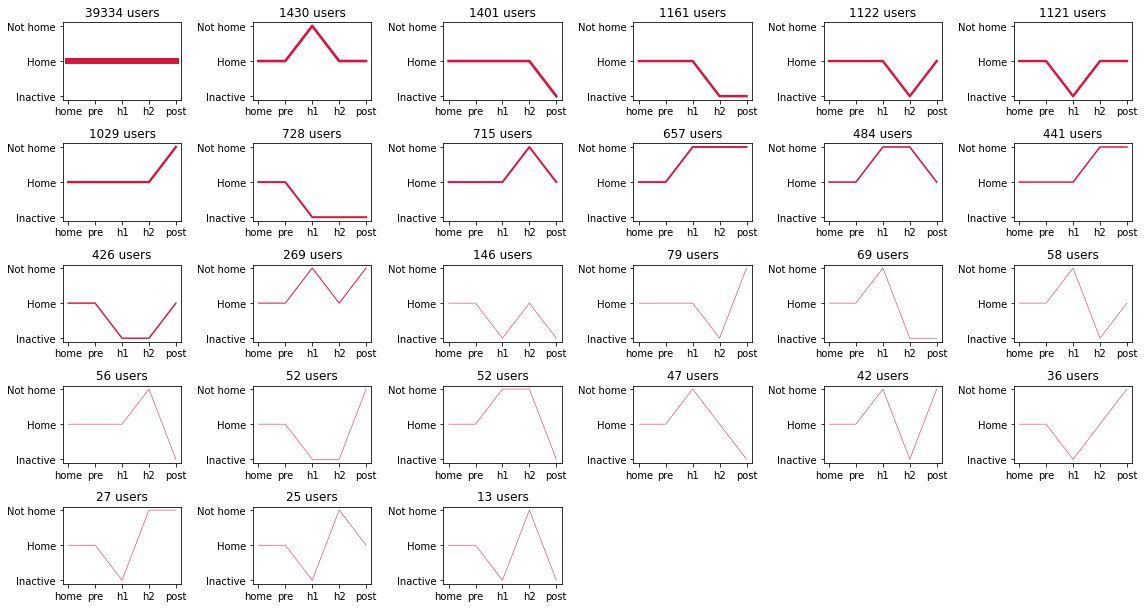

In [16]:
vol = tmp_color['id'].tolist()
linew = []
for v in vol:
    if v>200:
        linew.append(np.log(v/100))
    else:
        linew.append(0.5)

plt.figure(figsize=(16,10))
for i in range(len(tmp_color)):
    plt.subplot(6,6,i+1)
    plt.plot(range(5), tmp_color.iloc[i,0:5],color='crimson', linewidth=linew[i])
    plt.xticks(range(5), ['home','pre', 'h1', 'h2', 'post'])
    plt.yticks([-1,0,1], ['Inactive','Home','Not home'])
    plt.ylim(-1.1,1.1)
    plt.tight_layout()
    plt.title("%s users"%(vol[i]))

In [17]:
tmp3 = dd[['id', 'x_home', 'x_pre', 'x_h1', 'x_h2', 'x_post', 'y_home', 'y_pre', 'y_h1', 'y_h2', 'y_post']]
tmp3.index = tmp3['id']


for s in ['pre', 'h1', 'h2', 'post']:
    tmp3['loc_%s'%(s)] = 3 # out of Texas
    tmp3['loc_%s'%(s)][(tmp3['x_%s'%(s)]>=x3)&(tmp3['x_%s'%(s)]<=x4)&(tmp3['y_%s'%(s)]>=y3)&(tmp3['y_%s'%(s)]<=y4)] = 2 # Texas
    tmp3['loc_%s'%(s)][(tmp3['x_%s'%(s)]>=x1)&(tmp3['x_%s'%(s)]<=x2)&(tmp3['y_%s'%(s)]>=y1)&(tmp3['y_%s'%(s)]<=y2)] = 1 # Houston
    tmp3['loc_%s'%(s)][(tmp3['x_%s'%(s)]==tmp3['x_home'])&(tmp3['y_%s'%(s)]==tmp3['y_home'])] = 0
tmp3['loc_home'] = 0
    
tmp_loc2 = tmp3[['id','loc_home','loc_pre','loc_h1', 'loc_h2', 'loc_post']].groupby(['loc_home','loc_pre','loc_h1', 'loc_h2', 'loc_post']).count().reset_index()
tmp_loc2 = tmp_loc2.sort_values('id', ascending=False).reset_index(drop=True)
# print (len(tmp_loc2))
# print (tmp_loc2['id'].sum())
tmp_loc2.head(2)

,loc_home,loc_pre,loc_h1,loc_h2,loc_post,id
0,0,0,0,0,0,39177
1,0,0,1,0,0,952


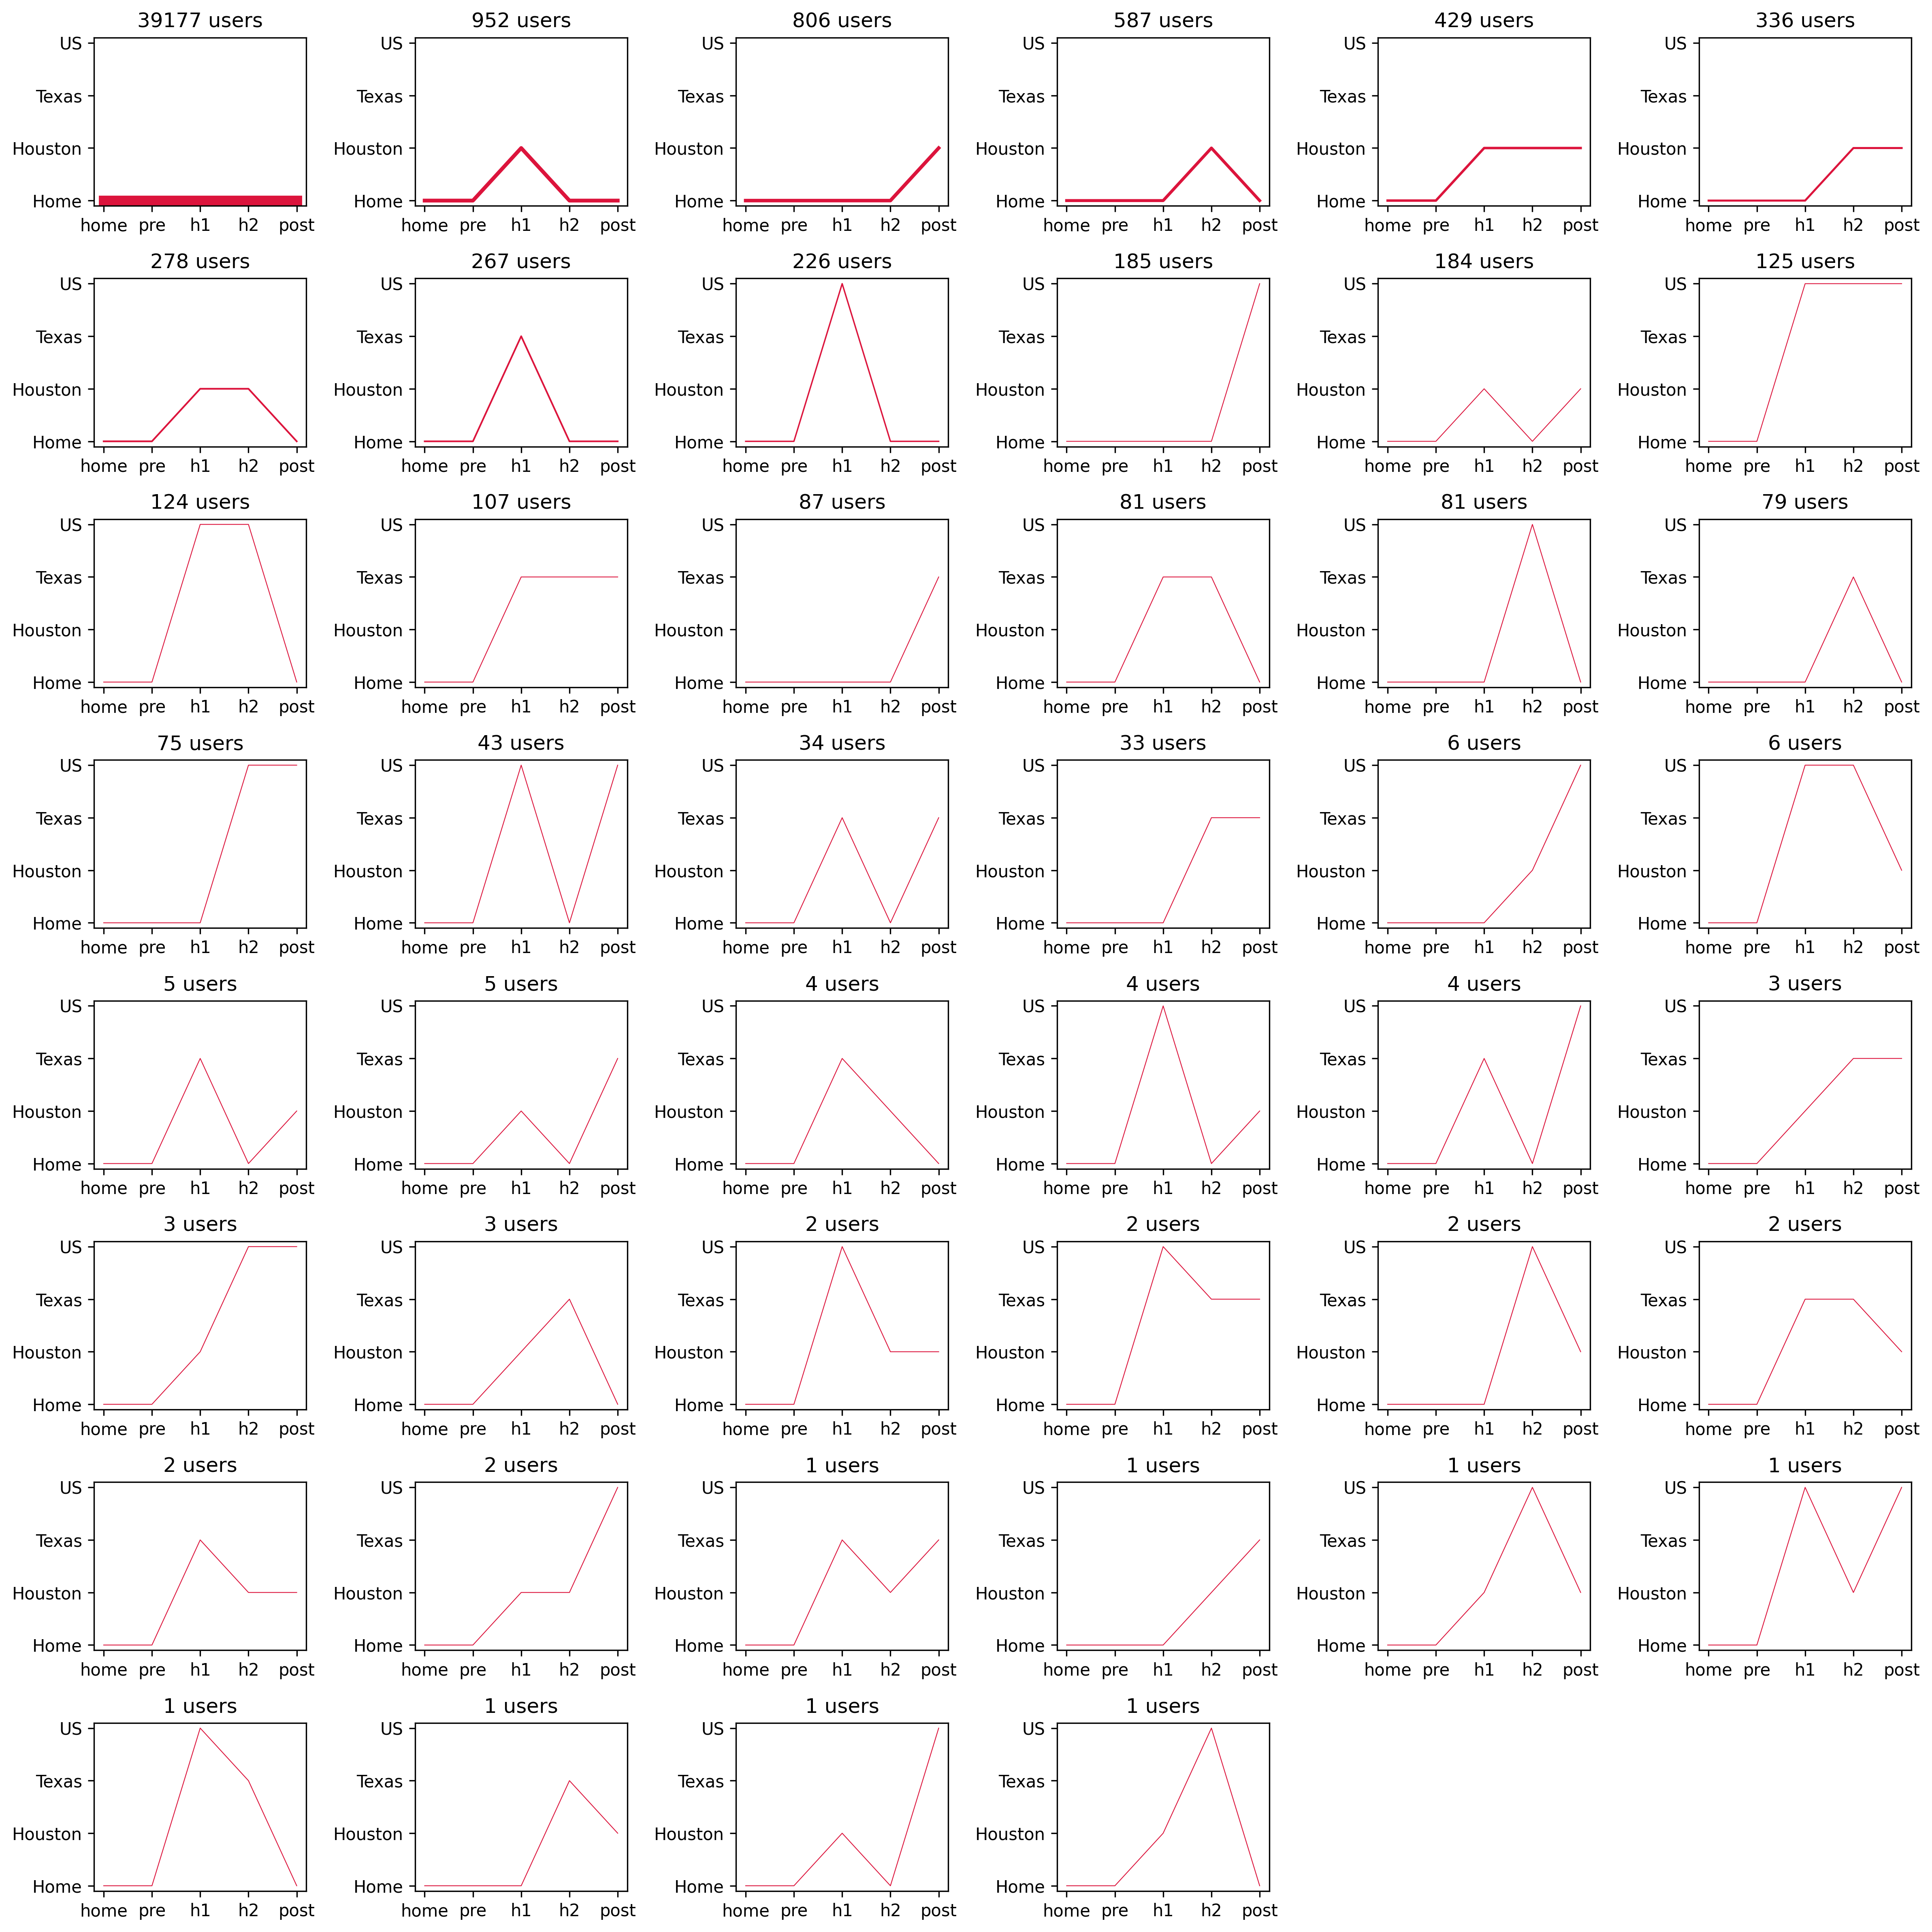

In [18]:
vol_loc2 = tmp_loc2['id'].tolist()
linew2 = []
for v in vol_loc2:
    if v>200:
        linew2.append(np.log(v/100))
    else:
        linew2.append(0.5)
plt.figure(figsize=(16,16), dpi=300)
for i in range(len(tmp_loc2)):
    plt.subplot(8,6,i+1)
    plt.plot(range(5), tmp_loc2.iloc[i,0:5], color='crimson', linewidth=linew2[i])
    plt.xticks(range(5), ['home', 'pre', 'h1', 'h2', 'post'])
    plt.yticks(range(4), ['Home', 'Houston', 'Texas', 'US'])
    plt.ylim(-0.1,3.1)
    plt.tight_layout()
    plt.title("%s users"%(vol_loc2[i]))

In [19]:
df.head(2)

,id,x_home,y_home,x_pre,y_pre,x_h1,y_h1,x_h2,y_h2,x_post,y_post
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-95.21,29.97,-90.00,35.00,-95.21,29.97,-95.21,29.97
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,-95.39,30.05,-95.39,30.05


# 4. Simplification of origin/destination

In [20]:
df2 = df.copy()
df2['x_h2'] = df2['x_h2'].fillna(df2['x_post'])
df2['y_h2'] = df2['y_h2'].fillna(df2['y_post'])
df2['x_h1'] = df2['x_h1'].fillna(df2['x_h2'])
df2['y_h1'] = df2['y_h1'].fillna(df2['y_h2'])

In [21]:
df2 = df2.fillna(0)
id_list = df2['id'].unique().tolist()
print (len(id_list))

cols = ['h1', 'h2', 'post']

x_list_o = []
y_list_o = []
x_list_d = []
y_list_d = []
for i in id_list:
    x = df2[df2['id']==i]['x_pre'].values[0]
    y = df2[df2['id']==i]['y_pre'].values[0]
    
    x_list_o.append(x)
    y_list_o.append(y)
    
    if df2[df2['id']==i]['x_h1'].values[0] != x and df2[df2['id']==i]['y_h1'].values[0] !=y:
        x = df2[df2['id']==i]['x_h1'].values[0]
        y = df2[df2['id']==i]['y_h1'].values[0]
    elif (df2[df2['id']==i]['x_h1'].values[0] == x and df2[df2['id']==i]['y_h1'].values[0] ==y) and \
    (df2[df2['id']==i]['x_h1'].values[0] != df2[df2['id']==i]['x_h2'].values[0] and \
     df2[df2['id']==i]['y_h1'].values[0] != df2[df2['id']==i]['y_h2'].values[0]):
        x = df2[df2['id']==i]['x_h2'].values[0]
        y = df2[df2['id']==i]['y_h2'].values[0]
    elif (df2[df2['id']==i]['x_h1'].values[0] == x and df2[df2['id']==i]['y_h1'].values[0] ==y) and \
    (df2[df2['id']==i]['x_h1'].values[0] == df2[df2['id']==i]['x_h2'].values[0] and \
     df2[df2['id']==i]['y_h1'].values[0] == df2[df2['id']==i]['y_h2'].values[0]) and \
    (df2[df2['id']==i]['x_h2'].values[0] != df2[df2['id']==i]['x_post'].values[0] and \
     df2[df2['id']==i]['y_h2'].values[0] != df2[df2['id']==i]['y_post'].values[0]):
        x = df2[df2['id']==i]['x_post'].values[0]
        y = df2[df2['id']==i]['y_post'].values[0]
    
    x_list_d.append(x)
    y_list_d.append(y)
    
df2_s = pd.DataFrame()
df2_s['id'] = id_list
df2_s['x_o'] = x_list_o
df2_s['y_o'] = y_list_o
df2_s['x_d'] = x_list_d
df2_s['y_d'] = y_list_d

df2_s.head(2)

In [23]:
df2_s = pd.merge(df2_s, df2[['id', 'x_home', 'y_home']], on='id', how='left')
df2_s.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05


In [24]:
df2_s = df2_s.replace(0,np.nan)
# df2_s.isnull().sum()

In [25]:
# id origin destination
# home, Houston, Texas, US encode (0,1,2,3) - loc_o, loc_d

for s in ['o', 'd']:
    df2_s['loc_%s'%(s)] = 3 # out of Texas
    df2_s['loc_%s'%(s)][(df2_s['x_%s'%(s)]>=x3)&(df2_s['x_%s'%(s)]<=x4)&(df2_s['y_%s'%(s)]>=y3)&(df2_s['y_%s'%(s)]<=y4)] = 2 # Texas
    df2_s['loc_%s'%(s)][(df2_s['x_%s'%(s)]>=x1)&(df2_s['x_%s'%(s)]<=x2)&(df2_s['y_%s'%(s)]>=y1)&(df2_s['y_%s'%(s)]<=y2)] = 1 # Houston
    df2_s['loc_%s'%(s)][(df2_s['x_%s'%(s)]==df2_s['x_home'])&(df2_s['y_%s'%(s)]==df2_s['y_home'])] = 0
    df2_s['loc_%s'%(s)][df2_s['x_%s'%(s)].isnull()] = -1
    
df2_s.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0


In [26]:
# df2_s.to_csv('../../outputs/user_origin_destination.csv', index=False)

In [27]:
df2_s_group = df2_s[['id', 'loc_o', 'loc_d']].groupby(['loc_o', 'loc_d']).count().reset_index()
df2_s_group

,loc_o,loc_d,id
0,0,-1,3423
1,0,0,42277
2,0,1,3624
3,0,2,756
4,0,3,940


In [28]:
# print (len(df2_s))

# 5. Network analysis
## Create 'cell_id'
* The grid cell id = 'lon_round' + 'lat_round' as string format

In [29]:
dx1 = 'x_o'
dy1 = 'y_o'
dx2 = 'x_d'
dy2 = 'y_d'

In [30]:
df2 = df2_s.copy()
for c in [dx1, dy1, dx2, dy2]:
    df2[c] = df2[c].astype(float).astype(str)
df2['%s_cell_id'%(dy1)] = df2[dx1] + ',' + df2[dy1]
df2['%s_cell_id'%(dy2)] = df2[dx2] + ',' + df2[dy2]
df2['weight'] =1
df2.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d,y_o_cell_id,y_d_cell_id,weight
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.0,35.0,-95.21,29.97,0,3,"-95.21,29.97","-90.0,35.0",1
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0,"-95.39,30.05","-95.39,30.05",1


In [31]:
tmp_home = df2[['%s_cell_id'%(dy1), dx1, dy1]]
tmp_home.columns = ['cell_id', 'x', 'y']
tmp_16 = df2[['%s_cell_id'%(dy2), dx2, dy2]]
tmp_16.columns = ['cell_id', 'x', 'y']

# print (len(tmp_home))
# print (len(tmp_16))
tmp = pd.concat([tmp_home, tmp_16])
# print (len(tmp))

In [32]:
# print (len(df2['%s_cell_id'%(dy1)].unique()))
# print (len(df2['%s_cell_id'%(dy2)].unique()))

In [33]:
tmp['x'] = tmp['x'].astype(float)
tmp['y'] = tmp['y'].astype(float)
tmp = tmp.drop_duplicates().reset_index(drop=True)
# print (len(tmp))
tmp.head(2)

,cell_id,x,y
0,"-95.21,29.97",-95.21,29.97
1,"-95.39,30.05",-95.39,30.05


In [34]:
tmp['pos'] = list(zip(tmp['x'], tmp['y']))

In [35]:
tmp['loc'] = 3 # out of Texas
tmp['loc'][(tmp['x']>=x3)&(tmp['x']<=x4)&(tmp['y']>=y3)&(tmp['y']<=y4)] = 2 # Texas
tmp['loc'][(tmp['x']>=x1)&(tmp['x']<=x2)&(tmp['y']>=y1)&(tmp['y']<=y2)] = 1 # Houston
tmp['loc'].value_counts()

1    5704
2     318
3     247
Name: loc, dtype: int64

## Created node data

In [36]:
# Creating Node data
node_list = np.unique(df2[['%s_cell_id'%(dy1), '%s_cell_id'%(dy2)]].values)

node = pd.DataFrame()
node['cell_id'] = node_list
node = pd.merge(node, tmp, how='left', on='cell_id')
node.index = node['cell_id']

new_node_list = node['cell_id'].unique().tolist()

# print (len(node))
# print (len(new_node_list))
node.head()

,cell_id,x,y,pos,loc
cell_id,,,,,
"-100.0,25.0","-100.0,25.0",-100.0,25.0,"(-100.0, 25.0)",3
"-100.0,26.0","-100.0,26.0",-100.0,26.0,"(-100.0, 26.0)",3
"-100.0,27.0","-100.0,27.0",-100.0,27.0,"(-100.0, 27.0)",3
"-100.0,28.0","-100.0,28.0",-100.0,28.0,"(-100.0, 28.0)",3
"-100.0,29.0","-100.0,29.0",-100.0,29.0,"(-100.0, 29.0)",3


## Create edge data

In [37]:
non_houston = df2[['y_d_cell_id', 'loc_d']].drop_duplicates().reset_index(drop=True)
non_houston.columns = ['cell_id', 'loc_d']
non_houston.head(2)

,cell_id,loc_d
0,"-90.0,35.0",3
1,"-95.39,30.05",0


In [38]:
# Creating edge data (origin - destination - weight)
edge_all = df2[['%s_cell_id'%(dy1), '%s_cell_id'%(dy2), 'loc_o', 'loc_d', 'weight']].groupby(['%s_cell_id'%(dy1), '%s_cell_id'%(dy2), 'loc_o', 'loc_d']).sum().reset_index()
edge_all.head()

,y_o_cell_id,y_d_cell_id,loc_o,loc_d,weight
0,"-94.75,29.99","-94.75,29.99",0,0,1
1,"-94.75,30.0","-94.75,30.0",0,0,1
2,"-94.75,30.13","-94.75,30.13",0,0,2
3,"-94.75,30.16","-94.75,30.16",0,0,1
4,"-94.75,30.19","-94.75,30.19",0,0,1


In [39]:
edge_all.columns = ['origin', 'destination','loc_o', 'loc_d','weight']
edge_all.head()

,origin,destination,loc_o,loc_d,weight
0,"-94.75,29.99","-94.75,29.99",0,0,1
1,"-94.75,30.0","-94.75,30.0",0,0,1
2,"-94.75,30.13","-94.75,30.13",0,0,2
3,"-94.75,30.16","-94.75,30.16",0,0,1
4,"-94.75,30.19","-94.75,30.19",0,0,1


In [40]:
# print (len(edge_all))
# print (len(edge_all[edge_all['origin']=='nan,nan']))
# print (len(edge_all[edge_all['destination']=='nan,nan']))

In [41]:
# drop nodes without location information
edge = edge_all[(edge_all['origin'].isin(new_node_list))&(edge_all['destination'].isin(new_node_list))]
edge = edge.reset_index(drop=True)
edge.head()

,origin,destination,loc_o,loc_d,weight
0,"-94.75,29.99","-94.75,29.99",0,0,1
1,"-94.75,30.0","-94.75,30.0",0,0,1
2,"-94.75,30.13","-94.75,30.13",0,0,2
3,"-94.75,30.16","-94.75,30.16",0,0,1
4,"-94.75,30.19","-94.75,30.19",0,0,1


In [42]:
# edge['color'] = 'k'
# edge['color'][edge['weight']>=10]='red'
# edge['color'][edge['origin'].str.contains('nan')] = 'white'
# edge['color'][edge['destination'].str.contains('nan')] = 'white'
# edge['color'].value_counts()

In [43]:
edge[edge['origin']!=edge['destination']].sort_values('weight', ascending=False).head()

,origin,destination,loc_o,loc_d,weight
5310,"-95.38,29.75","nan,nan",0,-1,6
6438,"-95.44,30.03","nan,nan",0,-1,6
9543,"-95.62,29.77","nan,nan",0,-1,6
6006,"-95.42,29.74","nan,nan",0,-1,6
10529,"-95.69,29.8","nan,nan",0,-1,5


In [44]:
edge[(edge['origin']!=edge['destination'])&(edge['origin']!='nan,nan')&(edge['destination']!='nan,nan')].sort_values('weight').tail()

,origin,destination,loc_o,loc_d,weight
10896,"-95.72,29.77","-97.9,29.9",0,2,2
8678,"-95.57,29.76","-95.58,29.74",0,1,2
262,"-94.88,30.12","-95.02,29.6",0,1,2
10631,"-95.7,29.77","-98.0,30.2",0,2,2
5983,"-95.42,29.7","-95.4,29.71",0,1,4


In [45]:
edge.head()

,origin,destination,loc_o,loc_d,weight
0,"-94.75,29.99","-94.75,29.99",0,0,1
1,"-94.75,30.0","-94.75,30.0",0,0,1
2,"-94.75,30.13","-94.75,30.13",0,0,2
3,"-94.75,30.16","-94.75,30.16",0,0,1
4,"-94.75,30.19","-94.75,30.19",0,0,1


In [46]:
# edge.to_csv('../../outputs/edge.csv', index=False)

In [47]:
# node.to_csv('../../outputs/node.csv', index=False)

# Create Network

In [48]:
# Create a network with node data
network = nx.DiGraph()
network.add_nodes_from(node.index)

# Create a dictionary of grid cell location
pos = {}
for c in node.index:
    pos[c] = (node['x'][c], node['y'][c])
    
# color = []
# for c in node.index:
#     color.append(node['color'][c])

In [49]:
# create a dictionary of grid cell users
# Num of users staying the same grid cells
num_s = {}
for c in node.index:
    geoid = node['cell_id'][c]
    num_s[c] = edge[(edge['origin']==geoid)&(edge['origin']==edge['destination'])]['weight'].sum()
    
# Num of users in-bound to grid cells
num_i = {}
for c in node.index:
    geoid = node['cell_id'][c]
    num_i[c] = edge[(edge['destination']==geoid)&(edge['origin']!=edge['destination'])]['weight'].sum()
    
# Num of users out-bound to grid cells
num_o = {}
for c in node.index:
    geoid = node['cell_id'][c]
    num_o[c] = edge[(edge['origin']==geoid)&(edge['origin']!=edge['destination'])]['weight'].sum()

# Num of users to NaN
num_to_n = {}
for c in node.index:
    geoid = node['cell_id'][c]
    num_to_n[c] = edge[(edge['origin']==geoid)&(edge['destination']=='nan,nan')]['weight'].sum()

# Num of users from NaN
num_from_n = {}
for c in node.index:
    geoid = node['cell_id'][c]
    num_from_n[c] = edge[(edge['destination']==geoid)&(edge['origin']=='nan,nan')]['weight'].sum()

In [50]:
# Create list of edges as tuples
EN = len(edge.index)
edgelist = [0]*EN
for j in range(0,EN):
    edgelist[j] = (edge['origin'][j], edge['destination'][j], {'weight': edge['weight'][j], 'color': edge['loc_d'][j]
#                                                                , 'alpha': edge['alpha'][j]
                                                              })

In [51]:
edgelist[0]

('-94.75,29.99', '-94.75,29.99', {'weight': 1, 'color': 0})

In [52]:
# Add edges to the network
network.add_edges_from(edgelist)

# Extract all the edges weight values
w = [d['weight'] for (u,v,d) in network.edges(data=True)]

edge_colors = [d['color'] for (u,v,d) in network.edges(data=True)]

print (edge_colors[:5])

[0, 0, 0, 0, 0]


## Node Centrality
* Now compute centrality metrics: degree

In [53]:
c1 = nx.degree(network)

In [54]:
result1 = pd.DataFrame(dict(c1).items(), columns = ['cell_id', 'degree'])

result_in = pd.DataFrame(list(num_i.items()), columns = ['cell_id', 'num_i'])
result_out = pd.DataFrame(list(num_o.items()), columns = ['cell_id', 'num_o'])
result_s = pd.DataFrame(list(num_s.items()), columns = ['cell_id', 'num_s'])
result_to_n = pd.DataFrame(list(num_to_n.items()), columns = ['cell_id', 'num_to_n'])
result_from_n = pd.DataFrame(list(num_from_n.items()), columns = ['cell_id', 'num_from_n'])

result = pd.merge(result1, result_in, how='left', on='cell_id')
result = pd.merge(result, result_out, how='left', on='cell_id')
result = pd.merge(result, result_s, how='left', on='cell_id')
result = pd.merge(result, result_to_n, how='left', on='cell_id')
result = pd.merge(result, result_from_n, how='left', on='cell_id')

result['in_out'] = result['num_i'] - result['num_o']
result['total'] = result['num_i'] + result['num_o'] + result['num_s']
result['pct_s'] = result['num_s']/result['total'].astype(float)
result['pct_in'] = result['num_i']/result['total'].astype(float)
result['pct_out'] = result['num_o']/result['total'].astype(float)

result.head(2)

,cell_id,degree,num_i,num_o,num_s,num_to_n,num_from_n,in_out,total,pct_s,pct_in,pct_out
0,"-100.0,25.0",1,1,0,0,0,0,1,1,0.0,1.0,0.0
1,"-100.0,26.0",7,7,0,0,0,0,7,7,0.0,1.0,0.0


In [55]:
result['pct_in_out'] = result['in_out']/result['total']

In [56]:
result.sort_values('num_i', ascending=False).head()

,cell_id,degree,num_i,num_o,num_s,num_to_n,num_from_n,in_out,total,pct_s,pct_in,pct_out,pct_in_out
6268,"nan,nan",2223,3423,0,0,0,0,3423,3423,0.000000,1.000000,0.000000,1.000000
640,"-95.0,29.0",74,76,0,0,0,0,76,76,0.000000,1.000000,0.000000,1.000000
6020,"-96.3,30.6",42,42,0,0,0,0,42,42,0.000000,1.000000,0.000000,1.000000
200,"-94.0,30.0",41,42,0,0,0,0,42,42,0.000000,1.000000,0.000000,1.000000
2915,"-95.4,29.71",53,41,16,4,0,0,25,61,0.065574,0.672131,0.262295,0.409836


In [57]:
# result.to_csv('../../outputs/node_result.csv', index=False)

In [58]:
result = pd.merge(result, non_houston, on='cell_id', how='left')
result.head(2)

,cell_id,degree,num_i,num_o,num_s,num_to_n,num_from_n,in_out,total,pct_s,pct_in,pct_out,pct_in_out,loc_d
0,"-100.0,25.0",1,1,0,0,0,0,1,1,0.0,1.0,0.0,1.0,3.0
1,"-100.0,26.0",7,7,0,0,0,0,7,7,0.0,1.0,0.0,1.0,3.0


## Exploring result 

In [59]:
degree_ = pd.Series(result['degree'].values, index=result['cell_id']).to_dict()
pct_in = pd.Series(result['pct_in'].values, index=result['cell_id']).to_dict()
pct_out = pd.Series(result['pct_out'].values, index=result['cell_id']).to_dict()
pct_s = pd.Series(result['pct_s'].values, index=result['cell_id']).to_dict()
cell_id = pd.Series(result['cell_id'].values, index=result['cell_id']).to_dict()

In [60]:
network2 = network.copy()

nx.set_node_attributes(network2, degree_, 'degree')
nx.set_node_attributes(network2, pct_s, 'pct_s')
nx.set_node_attributes(network2, pd.Series(result['pct_in'].values, index=result['cell_id']).to_dict(), 'pct_in')
nx.set_node_attributes(network2, pd.Series(result['pct_out'].values, index=result['cell_id']).to_dict(), 'pct_out')
nx.set_node_attributes(network2, pd.Series(result['num_s'].values, index=result['cell_id']).to_dict(), 'num_s')
nx.set_node_attributes(network2, pd.Series(result['num_i'].values, index=result['cell_id']).to_dict(), 'num_i')
nx.set_node_attributes(network2, pd.Series(result['num_o'].values, index=result['cell_id']).to_dict(), 'num_o')
nx.set_node_attributes(network2, pd.Series(result['cell_id'].values, index=result['cell_id']).to_dict(), 'cell_id')

In [61]:
network2.nodes['-95.4,29.71']

{'degree': 53,
 'pct_s': 0.06557377049180328,
 'pct_in': 0.6721311475409836,
 'pct_out': 0.26229508196721313,
 'num_s': 4,
 'num_i': 41,
 'num_o': 16,
 'cell_id': '-95.4,29.71'}

In [62]:
result.head(2)

,cell_id,degree,num_i,num_o,num_s,num_to_n,num_from_n,in_out,total,pct_s,pct_in,pct_out,pct_in_out,loc_d
0,"-100.0,25.0",1,1,0,0,0,0,1,1,0.0,1.0,0.0,1.0,3.0
1,"-100.0,26.0",7,7,0,0,0,0,7,7,0.0,1.0,0.0,1.0,3.0


In [63]:
selected_nodes_i = result[(result['cell_id']!='nan,nan')&(result['num_i']>result.sort_values(by='num_i', ascending=False)['num_i'].iloc[100])]['cell_id'].tolist()
selected_nodes_o = result[(result['cell_id']!='nan,nan')&(result['num_o']>result.sort_values(by='num_o', ascending=False)['num_o'].iloc[100])]['cell_id'].tolist()
selected_nodes_s = result[(result['cell_id']!='nan,nan')&(result['num_s']>result.sort_values(by='num_s', ascending=False)['num_s'].iloc[100])]['cell_id'].tolist()

selected_nodes_houston = result[(result['cell_id']!='nan,nan')&(result['loc_d']==1)]['cell_id'].tolist()
selected_nodes_texas = result[(result['cell_id']!='nan,nan')&(result['loc_d']==2)]['cell_id'].tolist()
selected_nodes_us = result[(result['cell_id']!='nan,nan')&(result['loc_d']==3)]['cell_id'].tolist()


# print (len(selected_nodes_i))
# print (len(selected_nodes_o))
# print (len(selected_nodes_s))
# print (len(selected_nodes_houston))
# print (len(selected_nodes_texas))
# print (len(selected_nodes_us))

In [64]:
network_i = network2.subgraph(selected_nodes_i)
network_o = network2.subgraph(selected_nodes_o)
network_s = network2.subgraph(selected_nodes_s)
network_houston = network2.subgraph(selected_nodes_houston)
network_texas = network2.subgraph(selected_nodes_texas)
network_us = network2.subgraph(selected_nodes_us)

In [65]:
result.sort_values(by='num_i', ascending=False).head(2)

,cell_id,degree,num_i,num_o,num_s,num_to_n,num_from_n,in_out,total,pct_s,pct_in,pct_out,pct_in_out,loc_d
8194,"nan,nan",2223,3423,0,0,0,0,3423,3423,0.0,1.0,0.0,1.0,-1.0
716,"-95.0,29.0",74,76,0,0,0,0,76,76,0.0,1.0,0.0,1.0,3.0


## Create subgraph associated with top inbound flows and outbound flows

In [66]:
inbound = list(network_i.nodes)
edge_inbound = edge[(edge['destination'].isin(inbound))&(edge['origin']!='nan,nan')]
I = network2.edge_subgraph(list(zip(edge_inbound['origin'], edge_inbound['destination'])))
# list(I.edges)

outbound = list(network_o.nodes)
edge_outbound = edge[(edge['origin'].isin(outbound))&(edge['destination']!='nan,nan')]
O = network2.edge_subgraph(list(zip(edge_outbound['origin'], edge_outbound['destination'])))

bound_houston = list(network_houston.nodes)
edge_houston = edge[(edge['destination'].isin(bound_houston))]
H = network2.edge_subgraph(list(zip(edge_houston['origin'], edge_houston['destination'])))

bound_texas = list(network_texas.nodes)
edge_texas = edge[(edge['destination'].isin(bound_texas))]
T = network2.edge_subgraph(list(zip(edge_texas['origin'], edge_texas['destination'])))

bound_us = list(network_us.nodes)
edge_us = edge[(edge['destination'].isin(bound_us))]
U = network2.edge_subgraph(list(zip(edge_us['origin'], edge_us['destination'])))

w_i = [d['weight'] for (u,v,d) in I.edges(data=True)]
w_o = [d['weight'] for (u,v,d) in O.edges(data=True)]
w_h = [d['weight'] for (u,v,d) in H.edges(data=True)]
w_t = [d['weight'] for (u,v,d) in T.edges(data=True)]
w_u = [d['weight'] for (u,v,d) in U.edges(data=True)]


print (w_i[:5])
print (w_o[:5])
print (w_h[:5])
print (w_t[:5])
print (w_u[:5])

[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 3]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


## Now visualize the network with the node size proportional to the degree; 
* first visualize just network topology, 
* next - visualize network in space with repsect to real geograohical context

In [67]:
# w = [d['weight'] for (u,v,d) in network2.edges(data=True)]
# edge_colors = [d['color'] for (u,v,d) in network.edges(data=True)]

In [68]:
r_pct_i = [v['pct_in'] for n, v in network2.nodes(data=True)]
r_pct_o = [v['pct_out'] for n, v in network2.nodes(data=True)]
r_pct_s = [v['pct_s'] for n, v in network2.nodes(data=True)]
r_num_i = [v['num_i'] for n, v in network2.nodes(data=True)]
r_num_o = [v['num_o'] for n, v in network2.nodes(data=True)]
r_num_s = [v['num_s'] for n, v in network2.nodes(data=True)]
r_degree = [v['degree'] for n, v in network2.nodes(data=True)]

w_h_r = [v['num_i'] for n, v in H.nodes(data=True)]
w_t_r = [v['num_i'] for n, v in T.nodes(data=True)]
w_u_r = [v['num_i'] for n, v in U.nodes(data=True)]


r_num_oo = [v['num_o'] for n,v in network_o.nodes(data=True)]
r_num_ii = [v['num_i'] for n,v in network_i.nodes(data=True)]
r_num_hh_i = [v['num_i'] for n,v in network_houston.nodes(data=True)]
r_num_hh_o = [v['num_o'] for n,v in network_houston.nodes(data=True)]

r_num_tt_i = [v['num_i'] for n,v in network_texas.nodes(data=True)]
r_num_tt_o = [v['num_o'] for n,v in network_texas.nodes(data=True)]
r_num_uu_i = [v['num_i'] for n,v in network_us.nodes(data=True)]
r_num_uu_o = [v['num_o'] for n,v in network_us.nodes(data=True)]
# w_n_r

In [69]:
# Load county boundary data
county = gpd.read_file('../../data/county boundary.shp')

In [70]:
county_color = ['none', 'k', 'none','none','none','none','none','none','none','none'] # only represent Harris County

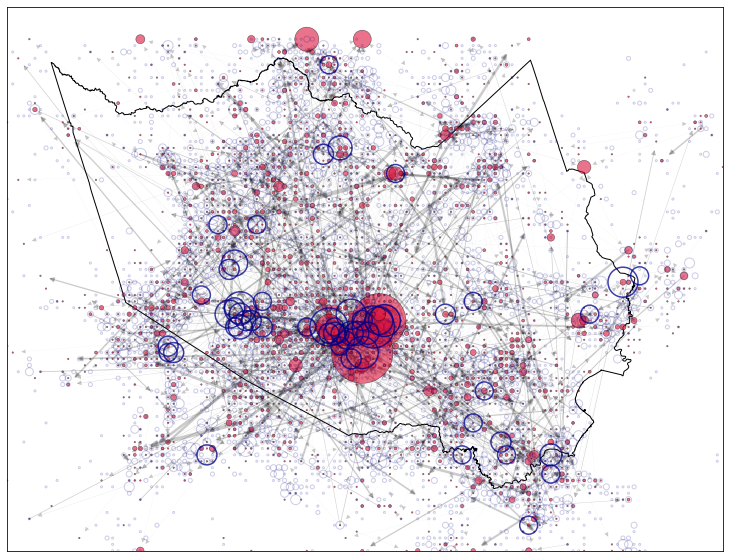

In [71]:
fig, ax = plt.subplots(figsize=(13,10))
# fig = plt.figure(figsize=(11,8), dpi=300)
# nx.draw(network2, pos=pos, with_label=False, node_size=((np.array(r_num_i))*2)**2, 
#                        style='solid', node_color='none',edgecolors='none', alpha=0.1, edge_color='grey', 
#        width=((np.array(w)/2)**4), arrows=False)


county.boundary.plot(color=county_color, linewidth=1, linestyle='-', ax=ax, alpha=1)

nx.draw_networkx_nodes(network_houston, pos=pos, edgecolors='k', node_color='crimson', linewidths=0.5, 
                       node_size=((np.array(r_num_hh_i))*1.5)**2, alpha=0.6, ax=ax)
# nx.draw_networkx_edges(network_houston, pos=pos, with_label=False, style='solid', edge_color='k',
#                        width=((np.array(w_h)/12)), alpha=0.2, arrow=True, connectionstyle='arc3,rad=0.2', ax=ax)
nx.draw_networkx_edges(network_houston, pos=pos, with_label=False, style='solid', edge_color='k',
                       width=((np.array(w_h)/12)), alpha=0.2, arrow=True, ax=ax)
nx.draw_networkx_nodes(network2, pos=pos, with_label=False, node_size=((np.array(r_num_o))*2)**2, 
                       style='solid', node_color='none',edgecolors='darkblue', alpha=0.2)
nx.draw_networkx_nodes(network_o, pos=pos, edgecolors='darkblue', node_color='none', linewidths=1.5, 
                       node_size=((np.array(r_num_oo))*2)**2, alpha=0.7)

plt.xlim(x1,x2)
plt.ylim(y1,y2+0.05)

# plt.savefig('../../figures/Fig3_a.png', format='png', dpi=300)
plt.show()